In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *


2024-02-02 22:46:33.543201: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 22:46:34.184573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-02 22:46:34.184656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-02 22:46:34.184663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Max mutual information vs sampling density for different samples

In [2]:
from scipy.signal import resample

N_objects = 10000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36] 
num_bootstrap_samples = 11
upsampling_factor = 256
max_epochs = 5000

confidence = 90
num_nyquist_samples = 16
object_names = ['white_noise', 'delta_uniform', '8_deltas_uniform']

# Fro debugging
# # object_names = ['delta_uniform',]
# max_epochs = 500
# # num_nyquist_samples = 16
# num_samples_list = [4]
# num_bootstrap_samples = 1



upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_8_delta = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


# for debugging
fake_images_dict = {}
output_signals_dict = {}



mi_by_object = {}
mi_by_object_hi = {}
mi_by_object_lo = {}
for name in object_names:
  print(name)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  if name == 'delta_uniform':
    objects_fn = objects_fn_delta
  elif name == '8_deltas_uniform':
    objects_fn = objects_fn_8_delta
  else:
    objects_fn = objects_fn_white_noise



  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    runs = []
    for i in range(num_bootstrap_samples):
        # Find an optimal PSF for this object
      initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

      # do the estimation
      scale_factor = 1000000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      # normalize to sum to 1
      resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
      pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

      # amount of noise to add to the pixel depends on its area
      relative_sampling_area = num_nyquist_samples / num_samples
      pixel_variance = noise_sigma**2 * relative_sampling_area

      noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

      fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor

      fake_images_dict[name] = fake_images
      output_signals_dict[name] = output_signals

      mi_estimate = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
      print(name, ': ', mi_estimate)
      runs.append(mi_estimate)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_object[name] = mutual_information
  mi_by_object_hi[name] = mi_hi
  mi_by_object_lo[name] = mi_lo

white_noise


  0%|                                                       | 0/6 [00:00<?, ?it/s]

initial loss -0.18263497685915195
computing optimized mi
white_noise :  0.014883671921051994
initial loss -0.07329013589160491
computing optimized mi
white_noise :  -0.02253700118428136
initial loss -0.17981616452311133
computing optimized mi
white_noise :  -0.04985334958612298
initial loss -0.06919598701661342
computing optimized mi
white_noise :  0.017790866651236914
initial loss -0.15523737562355866
computing optimized mi
white_noise :  -0.0015895143091912676
initial loss -0.08542758632391283
computing optimized mi
white_noise :  0.014342958466739325
initial loss -0.07276012275066851
computing optimized mi
white_noise :  0.030225900239221427
initial loss -0.06099652451558865
computing optimized mi
white_noise :  -0.015090840332525198
initial loss -0.07245263833934751
computing optimized mi
white_noise :  0.04495724618152617
initial loss -0.1871518983258743
computing optimized mi
white_noise :  0.06068471563762829
initial loss -0.06496423552296386
computing optimized mi
white_noise :

 17%|███████▏                                   | 1/6 [31:51<2:39:18, 1911.71s/it]

initial loss -0.1641527058151233
computing optimized mi
white_noise :  1.1854601926304065
initial loss -0.06353392489190128
computing optimized mi
white_noise :  1.136670778372438
initial loss -0.11857543104615376
computing optimized mi
white_noise :  1.1413775995612514
initial loss -0.07192479637012378
computing optimized mi
white_noise :  1.1821127223140127
initial loss -0.14529846493782445
computing optimized mi
white_noise :  1.1755416091898465
initial loss -0.09549633791158338
computing optimized mi
white_noise :  1.1823768876657381
initial loss -0.10760782500943271
computing optimized mi
white_noise :  1.1505876144802565
initial loss -0.06387536766584594
computing optimized mi
white_noise :  1.1554884320992431
initial loss -0.08253162480381938
computing optimized mi
white_noise :  1.1689085823113698
initial loss -0.052686668738560184
computing optimized mi
white_noise :  1.212791675505524
initial loss -0.10225700606379196
computing optimized mi


 33%|█████████████▋                           | 2/6 [1:05:34<2:11:48, 1977.23s/it]

white_noise :  1.1968344372278692
initial loss -0.07249277220238251
computing optimized mi
white_noise :  1.1692332596894934
initial loss -0.05247026882768672
computing optimized mi
white_noise :  1.1641480766687817
initial loss -0.09182773135327067
computing optimized mi
white_noise :  1.1729783538946819
initial loss -0.06411714319973953
computing optimized mi
white_noise :  1.171214499827433
initial loss -0.10669961876689352
computing optimized mi
white_noise :  1.2130599425741646
initial loss -0.10863333176510659
computing optimized mi
white_noise :  1.1767908652990087
initial loss -0.14930681646869398
computing optimized mi
white_noise :  1.1566331227566806
initial loss -0.07164417776850762
computing optimized mi
white_noise :  1.1684380119119038
initial loss -0.09411125083180699
computing optimized mi
white_noise :  1.1670263783136217
initial loss -0.06936412414593461
computing optimized mi
white_noise :  1.2180997221750482
initial loss -0.1076294118666529
computing optimized mi


 50%|████████████████████▌                    | 3/6 [1:38:57<1:39:27, 1989.07s/it]

white_noise :  1.1964189012766793
initial loss -0.13285175779002462
computing optimized mi
white_noise :  0.9183511831051294
initial loss -0.08197389761724774
computing optimized mi
white_noise :  0.9030130823705806
initial loss -0.044516144116875295
computing optimized mi
white_noise :  0.9510774177725115
initial loss -0.09811518076250306
computing optimized mi
white_noise :  0.9013317799757459
initial loss -0.08763535691992339
computing optimized mi
white_noise :  0.9185245416171991
initial loss -0.05857125368287705
computing optimized mi
white_noise :  0.9086169650662944
initial loss -0.08408195727473264
computing optimized mi
white_noise :  0.8961681728662408
initial loss -0.06420809948749401
computing optimized mi
white_noise :  0.9574228896587457
initial loss -0.16802470606097328
computing optimized mi
white_noise :  0.9099859469671624
initial loss -0.10663685915570542
computing optimized mi
white_noise :  0.9207300471318638
initial loss -0.11574227003384494
computing optimized m

 67%|███████████████████████████▎             | 4/6 [2:07:56<1:03:00, 1890.04s/it]

white_noise :  0.9103078984895775
initial loss -0.11299930410450026
computing optimized mi
white_noise :  0.636734369944205
initial loss -0.07992906604299628
computing optimized mi
white_noise :  0.6313286112622851
initial loss -0.05307731677777906
computing optimized mi
white_noise :  0.6291547505553793
initial loss -0.07807793216609932
computing optimized mi
white_noise :  0.6404835917330142
initial loss -0.10633693451304684
computing optimized mi
white_noise :  0.6261856420708838
initial loss -0.12980332521608123
computing optimized mi
white_noise :  0.6272037793639915
initial loss -0.08862461860290816
computing optimized mi
white_noise :  0.6231518681096638
initial loss -0.12039122814488859
computing optimized mi
white_noise :  0.6410669568847408
initial loss -0.12149182798473107
computing optimized mi
white_noise :  0.6176828198122265
initial loss -0.051697082905255085
computing optimized mi
white_noise :  0.6293033435657247
initial loss -0.13757317682439296
computing optimized mi

 83%|███████████████████████████████████▊       | 5/6 [2:36:19<30:22, 1822.74s/it]

white_noise :  0.6550071826330767
initial loss -0.04509105470160715
computing optimized mi
white_noise :  0.4496970577760635
initial loss -0.11693620465138008
computing optimized mi
white_noise :  0.45184202539762447
initial loss -0.07969356875486594
computing optimized mi
white_noise :  0.4465270735553602
initial loss -0.08483270044198389
computing optimized mi
white_noise :  0.4682945737097642
initial loss -0.05580072272299724
computing optimized mi
white_noise :  0.4377738445570467
initial loss -0.07834236802078332
computing optimized mi
white_noise :  0.43685201754842207
initial loss -0.10242405419309883
computing optimized mi
white_noise :  0.4405186876648171
initial loss -0.13699035035674137
computing optimized mi
white_noise :  0.4549184510562584
initial loss -0.14546706876261323
computing optimized mi
white_noise :  0.4493393338622689
initial loss -0.1467738693372138
computing optimized mi
white_noise :  0.45329355897090656
initial loss -0.06126574211274384
computing optimized 

100%|███████████████████████████████████████████| 6/6 [3:05:47<00:00, 1857.88s/it]


white_noise :  0.45395947579504736
delta_uniform


  0%|                                                       | 0/6 [00:00<?, ?it/s]

initial loss -3.8281565928047865
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.02% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  -0.02218202899290052
initial loss -4.343358768418401
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.01% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  -0.05412402277234825
initial loss -4.520908696386927
computing optimized mi
delta_uniform :  -0.04771113368697584
initial loss -3.6342536518148627
computing optimized mi
delta_uniform :  0.007144452632225606
initial loss -4.156643957502019
computing optimized mi
delta_uniform :  0.03544316593579559
initial loss -4.262474333207258
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.04% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  -0.04229299225419392
initial loss -3.7422949070066203
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.03% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  0.03886906034098274
initial loss -3.946670808664156
computing optimized mi
delta_uniform :  -0.0541529158576932
initial loss -3.790807696105385
computing optimized mi
delta_uniform :  -0.0032873270385089144
initial loss -4.1430475871220604
computing optimized mi
delta_uniform :  0.0020675247787554953
initial loss -4.17513196757605
computing optimized mi


 17%|███████▏                                   | 1/6 [28:05<2:20:27, 1685.45s/it]

delta_uniform :  0.06049897437469646
initial loss -3.92272740276361
computing optimized mi
delta_uniform :  7.040489841329726
initial loss -4.5119484564571275
computing optimized mi
delta_uniform :  7.232224355678826
initial loss -4.140285414354737
computing optimized mi
delta_uniform :  7.315214927817976
initial loss -3.2783191862744916
computing optimized mi
delta_uniform :  7.1467668643957
initial loss -3.5574538654426675
computing optimized mi
delta_uniform :  7.3189242496317855
initial loss -3.697875931478493
computing optimized mi
delta_uniform :  6.0504435064832265
initial loss -3.745306560459463
computing optimized mi
delta_uniform :  7.191774036195894
initial loss -4.243340328178492
computing optimized mi
delta_uniform :  5.285492192669592
initial loss -3.7709797659533457
computing optimized mi
delta_uniform :  6.325458899686134
initial loss -4.340639373315856
computing optimized mi
delta_uniform :  6.778428181389806
initial loss -3.2911621737439605
computing optimized mi


 33%|█████████████▋                           | 2/6 [1:02:22<2:06:56, 1904.04s/it]

delta_uniform :  7.285087694970433
initial loss -4.493911204381253
computing optimized mi
delta_uniform :  7.151373221849704
initial loss -3.9023683772772513
computing optimized mi
delta_uniform :  5.509648850492644
initial loss -3.9244061096092153
computing optimized mi
delta_uniform :  6.531942620306523
initial loss -3.479978932480151
computing optimized mi
delta_uniform :  5.34633412523332
initial loss -3.5226387771229
computing optimized mi
delta_uniform :  6.830911757121602
initial loss -4.282205189666149
computing optimized mi
delta_uniform :  4.014482590756041
initial loss -4.263333700448187
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.00% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  6.863811350301054
initial loss -3.9976325970232773
computing optimized mi
delta_uniform :  5.925623976065122
initial loss -4.236757461587733
computing optimized mi
delta_uniform :  9.892857852414082
initial loss -3.6420686137316416
computing optimized mi
delta_uniform :  7.024191363606054
initial loss -4.434111391169353
computing optimized mi


 50%|████████████████████▌                    | 3/6 [1:35:39<1:37:19, 1946.62s/it]

delta_uniform :  6.803501850157691
initial loss -4.283624444512943
computing optimized mi
delta_uniform :  2.381894648862286
initial loss -3.9430243347808007
computing optimized mi
delta_uniform :  5.064793733375549
initial loss -4.219751162552027
computing optimized mi
delta_uniform :  5.333265530678427
initial loss -3.853579097007488
computing optimized mi
delta_uniform :  3.0686488909816187
initial loss -4.135123870085126
computing optimized mi
delta_uniform :  5.0989797567834545
initial loss -4.122327941897584
computing optimized mi
delta_uniform :  2.6845222006265184
initial loss -4.432285117938494
computing optimized mi
delta_uniform :  3.8837957492066764
initial loss -3.9755525754507017
computing optimized mi
delta_uniform :  2.738345891040543
initial loss -3.9366629121555974
computing optimized mi
delta_uniform :  2.212114751791728
initial loss -3.9020436918457504
computing optimized mi
delta_uniform :  6.328670844925813
initial loss -4.290786846674755
computing optimized mi


 67%|███████████████████████████▎             | 4/6 [2:10:43<1:06:56, 2008.46s/it]

delta_uniform :  3.6626797187841738
initial loss -4.239662621412522
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.91% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.4141165897622037
initial loss -3.965804498632574
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.65% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  5.879754812450376
initial loss -3.763938899819906
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 1.05% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.6321809600277966
initial loss -4.0944812765941725
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.62% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  5.989808574529297
initial loss -4.203954572233448
computing optimized mi
delta_uniform :  5.419538869769948
initial loss -4.0358300499284505
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.94% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.65855484350291
initial loss -4.5625914671011305
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.76% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.501332431667751
initial loss -3.88871106237916
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.83% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.9786173084810108
initial loss -4.283795986265952
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.84% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.687474070210793
initial loss -3.5233944012055165
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.87% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  5.901254019669433
initial loss -4.175401918980113
computing optimized mi


 83%|███████████████████████████████████▊       | 5/6 [2:44:54<33:43, 2023.90s/it]

delta_uniform :  3.4228024070570497
initial loss -4.34984892544675
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.43% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.511237268516836
initial loss -4.315119995664324
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.91% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.5766979930188416
initial loss -3.8218957826383866
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.53% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.6687210939813064
initial loss -3.8534175596677955
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.69% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  3.299233572363319
initial loss -3.6183989795207965
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.61% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  2.8802535659149653
initial loss -4.1955967040482856
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.56% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  3.139446555238494
initial loss -4.213389447503947
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.55% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  4.564791986308417
initial loss -4.005940986669978
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 3.00% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.8938876597969299
initial loss -4.30087361161675
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.38% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  1.3762047462266
initial loss -4.622543231723569
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.13% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


delta_uniform :  5.6799852806735585
initial loss -4.100155905881431
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.59% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|███████████████████████████████████████████| 6/6 [3:18:38<00:00, 1986.34s/it]


delta_uniform :  5.52788382425049
8_deltas_uniform


  0%|                                                       | 0/6 [00:00<?, ?it/s]

initial loss -2.706743748473575
computing optimized mi
8_deltas_uniform :  -0.025973902479123727
initial loss -2.6337195906902764
computing optimized mi
8_deltas_uniform :  0.051276576704829206
initial loss -2.611660445199867
computing optimized mi
8_deltas_uniform :  0.09357467778863181
initial loss -2.5029484456009747
computing optimized mi
8_deltas_uniform :  0.0531670100031132
initial loss -2.332652918730568
computing optimized mi
8_deltas_uniform :  -0.02304331810842147
initial loss -2.550016102826557
computing optimized mi
8_deltas_uniform :  -0.08507126889920548
initial loss -2.9284450854048614
computing optimized mi
8_deltas_uniform :  -0.006604528408350767
initial loss -2.77670581625412
computing optimized mi
8_deltas_uniform :  0.05955650944796827
initial loss -2.914593591456341
computing optimized mi
8_deltas_uniform :  -0.002669565356609706
initial loss -2.709894274749777
computing optimized mi
8_deltas_uniform :  0.02230231554867011
initial loss -3.0447875956311714
computi

 17%|███████▏                                   | 1/6 [27:10<2:15:50, 1630.18s/it]

8_deltas_uniform :  0.07081518170405117
initial loss -2.7328286745100456
computing optimized mi
8_deltas_uniform :  5.7991782294338705
initial loss -2.897833306245454
computing optimized mi
8_deltas_uniform :  5.542339338635352
initial loss -2.978573705213178
computing optimized mi
8_deltas_uniform :  5.767523790646665
initial loss -2.997331651835995
computing optimized mi
8_deltas_uniform :  5.736322010196531
initial loss -2.912772964851162
computing optimized mi
8_deltas_uniform :  5.709309727121415
initial loss -2.551248562973624
computing optimized mi
8_deltas_uniform :  5.671382737091942
initial loss -2.5105529306602206
computing optimized mi
8_deltas_uniform :  5.828880321168481
initial loss -2.7956846009892304
computing optimized mi
8_deltas_uniform :  5.8162554187339435
initial loss -2.343397980994947
computing optimized mi
8_deltas_uniform :  5.7869454474433
initial loss -2.680919525347902
computing optimized mi
8_deltas_uniform :  5.842502722978022
initial loss -2.21290668525

 33%|█████████████▋                           | 2/6 [1:02:14<2:07:16, 1909.18s/it]

8_deltas_uniform :  5.695346111732562
initial loss -2.9854964571987272
computing optimized mi
8_deltas_uniform :  5.50229487234175
initial loss -2.847557249046116
computing optimized mi
8_deltas_uniform :  5.4906660934210105
initial loss -2.6881368591576607
computing optimized mi
8_deltas_uniform :  5.621588918286228
initial loss -2.5768637210466583
computing optimized mi
8_deltas_uniform :  5.542501664391061
initial loss -2.742685994002783
computing optimized mi
8_deltas_uniform :  5.557524692909229
initial loss -2.600782825789919
computing optimized mi
8_deltas_uniform :  5.570397250361008
initial loss -2.370149165076823
computing optimized mi
8_deltas_uniform :  5.703449908374512
initial loss -2.7122286988661064
computing optimized mi
8_deltas_uniform :  5.513073369036624
initial loss -3.119577027659621
computing optimized mi
8_deltas_uniform :  5.7102673006547136
initial loss -2.8221081618929076
computing optimized mi
8_deltas_uniform :  5.5397540695608765
initial loss -2.770146885

 50%|████████████████████▌                    | 3/6 [1:36:45<1:39:08, 1982.84s/it]

8_deltas_uniform :  5.602791902477527
initial loss -2.940263388910638
computing optimized mi
8_deltas_uniform :  5.121618177081828
initial loss -2.5504709272288855
computing optimized mi
8_deltas_uniform :  5.141514505994844
initial loss -2.938530706214704
computing optimized mi
8_deltas_uniform :  5.113949126714553
initial loss -2.816531609428594
computing optimized mi
8_deltas_uniform :  5.133041952682739
initial loss -2.8813658506455986
computing optimized mi
8_deltas_uniform :  5.295550423274817
initial loss -2.541880209165302
computing optimized mi
8_deltas_uniform :  5.164923408569083
initial loss -2.67813348824948
computing optimized mi
8_deltas_uniform :  4.845215915782363
initial loss -2.449454491285139
computing optimized mi
8_deltas_uniform :  5.21197648598394
initial loss -2.4543381947725504
computing optimized mi
8_deltas_uniform :  5.143893370021579
initial loss -3.1225083445802366
computing optimized mi
8_deltas_uniform :  4.794130189170074
initial loss -2.67710565927070

 67%|███████████████████████████▎             | 4/6 [2:08:29<1:05:03, 1951.78s/it]

8_deltas_uniform :  5.132224691125839
initial loss -2.4845454255040593
computing optimized mi
8_deltas_uniform :  3.283755121765072
initial loss -2.880011449003575
computing optimized mi
8_deltas_uniform :  3.3807354506560063
initial loss -2.9987818744326566
computing optimized mi
8_deltas_uniform :  3.4117735036225194
initial loss -2.6588992434963363
computing optimized mi
8_deltas_uniform :  3.3041894124099875
initial loss -2.604954714337486
computing optimized mi
8_deltas_uniform :  3.399066049515568
initial loss -3.2954631162657546
computing optimized mi
8_deltas_uniform :  4.215314972567355
initial loss -3.229453502580772
computing optimized mi
8_deltas_uniform :  3.747482262245515
initial loss -2.9447490781030083
computing optimized mi
8_deltas_uniform :  3.3314823711713117
initial loss -2.538085360601211
computing optimized mi
8_deltas_uniform :  3.2872470575081905
initial loss -3.100048408170445
computing optimized mi
8_deltas_uniform :  3.283433170242657
initial loss -2.813735

 83%|███████████████████████████████████▊       | 5/6 [2:40:23<32:18, 1938.11s/it]

8_deltas_uniform :  3.3125656554376097
initial loss -2.7333637643129727
computing optimized mi
8_deltas_uniform :  2.3627123660489464
initial loss -2.5057425893680776
computing optimized mi
8_deltas_uniform :  2.333552363629855
initial loss -2.896287819508939
computing optimized mi
8_deltas_uniform :  2.3372162820238365
initial loss -2.7356199568910524
computing optimized mi
8_deltas_uniform :  2.3620299388903225
initial loss -2.807853557127908
computing optimized mi
8_deltas_uniform :  2.391593068643036
initial loss -2.6675839883932664
computing optimized mi
8_deltas_uniform :  2.3631031106317066
initial loss -2.3308424387343676
computing optimized mi
8_deltas_uniform :  2.4533320885803707
initial loss -2.914558008480873
computing optimized mi
8_deltas_uniform :  2.3344714389160663
initial loss -2.7163932366017187
computing optimized mi
8_deltas_uniform :  2.400113777097383
initial loss -2.9220656019299573
computing optimized mi
8_deltas_uniform :  2.3496320535549247
initial loss -2.8

100%|███████████████████████████████████████████| 6/6 [3:12:31<00:00, 1925.31s/it]

8_deltas_uniform :  2.4821550050037704


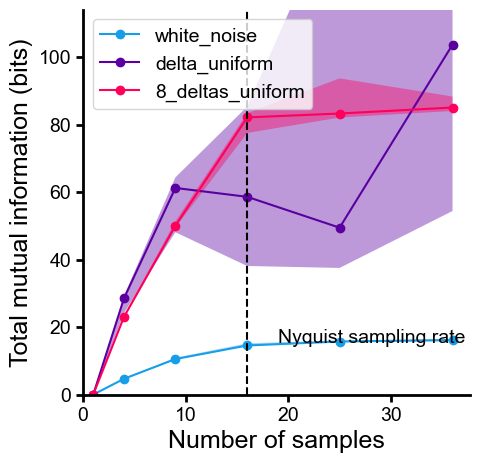

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for object_name, mutual_information in mi_by_object.items():
    total_mi = np.array(mutual_information) * np.array(num_samples_list)

    ax.plot(num_samples_list, total_mi, 'o-', label=object_name)
    ax.fill_between(num_samples_list, np.array(mi_by_object_lo[object_name]) * np.array(num_samples_list), 
                            np.array(mi_by_object_hi[object_name]) * np.array(num_samples_list), alpha=0.4)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])), xlim=(0, ax.get_xlim()[1]))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'mi_vs_sampling_density' + '.pdf', transparent=True)
